# Naver Finance Crawler

## Install & Update Libraries

In [107]:
!pip install --quiet --upgrade pip requests beautifulsoup4 pandas pd matplotlib seaborn selenium

!wget -q -O - https://dl-ssl.google.com/linux/linux_signing_key.pub | apt-key add -
!echo 'deb [arch=amd64] http://dl.google.com/linux/chrome/deb/ stable main' | tee /etc/apt/sources.list.d/google-chrome.list
!apt-get update
!apt-get install -y google-chrome-stable

!google-chrome --version

!wget -N https://chromedriver.storage.googleapis.com/88.0.4324.27/chromedriver_linux64.zip

!unzip chromedriver_linux64.zip
!chmod +x chromedriver
!mv -f chromedriver /usr/local/share/chromedriver
!ln -s /usr/local/share/chromedriver /usr/local/bin/chromedriver
!ln -s /usr/local/share/chromedriver /usr/bin/chromedriver
!rm chromedriver_linux64.zip
!apt-get update
!apt-get install -y libgconf-2-4

In [108]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
requests.__version__, pd.__version__, np.__version__, sns.__version__

('2.25.1', '1.2.1', '1.19.4', '0.11.1')

In [109]:
import bs4
import matplotlib
bs4.__version__, matplotlib.__version__

('4.9.3', '3.3.3')

from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

## Crawling Using 'requests', 'BeautifulSoup', and 'selenium'

### Check Existence

In [110]:
stock_code = "111111"
url = f"https://finance.daum.net/quotes/A{stock_code}#home"
url

'https://finance.daum.net/quotes/A111111#home'

In [111]:
html = requests.get(url)
html.raise_for_status()
html.text

"\n        <script>\n            alert('존재하지 않는 종목이거나 데이터를 불러오지 못했습니다.');\n            history.back();\n        </script>\n    "

In [112]:
try:
    if not ("alert" not in html.text):
        raise ValueError("Nonexistent stock code")
except ValueError as e:
    print("ValueError:", e)

ValueError: Nonexistent stock code


### Stock Price (Using Naver)

In [113]:
stock_code = '005930'
period = 3000
params = {
    'symbol': stock_code,
    'timeframe': 'day',
    'count': period,
    'requestType': 0,
}
url = "https://fchart.stock.naver.com/sise.nhn"
url, params

('https://fchart.stock.naver.com/sise.nhn',
 {'symbol': '005930', 'timeframe': 'day', 'count': 3000, 'requestType': 0})

In [114]:
html = requests.get(url, params=params)
html.raise_for_status()
html.url

'https://fchart.stock.naver.com/sise.nhn?symbol=005930&timeframe=day&count=3000&requestType=0'

In [115]:
parser = BeautifulSoup(html.text, 'html.parser')
items = parser.find_all('item')
items[:5]

[<item data="20081204|8920|8930|8540|8610|699805"></item>,
 <item data="20081205|8510|8740|8510|8540|591562"></item>,
 <item data="20081208|8690|9300|8600|9280|808511"></item>,
 <item data="20081209|9320|9390|9060|9390|593059"></item>,
 <item data="20081210|9380|9620|9320|9620|745554"></item>]

In [116]:
prices = pd.DataFrame(
        map(lambda item: item.get('data').split('|'),
            items
            ),
        columns=['Date', 'Start', 'High', 'Low', 'End', 'Amount']
    ).astype({
        'Date': 'datetime64',
        'Start': 'int32',
        'High': 'int32',
        'Low': 'int32',
        'End': 'int32',
        'Amount': 'int64',
    }).set_index('Date')
prices

,Start,High,Low,End,Amount
Date,,,,,
2008-12-04,8920,8930,8540,8610,699805
2008-12-05,8510,8740,8510,8540,591562
2008-12-08,8690,9300,8600,9280,808511
2008-12-09,9320,9390,9060,9390,593059
2008-12-10,9380,9620,9320,9620,745554
...,...,...,...,...,...
2021-01-18,86600,87300,84100,85000,43227951
2021-01-19,84500,88000,83600,87000,39895044
2021-01-20,89000,89000,86500,87200,25211127


In [117]:
prices.dtypes

Start     int32
High      int32
Low       int32
End       int32
Amount    int64
dtype: object

### Financial (Using Naver Main Table)

In [118]:
stock_code = "005930"
params = {
    'code': stock_code,
}
url = "https://finance.naver.com/item/main.nhn"
url, params

('https://finance.naver.com/item/main.nhn', {'code': '005930'})

In [119]:
html = requests.get(url, params)
html.url

'https://finance.naver.com/item/main.nhn?code=005930'

In [120]:
parser = BeautifulSoup(html.text, 'html.parser')
table = parser.find('table', class_="tb_type1 tb_num tb_type1_ifrs")
table

<table class="tb_type1 tb_num tb_type1_ifrs" summary="기업실적분석에 관한표이며 주요재무정보를 최근 연간 실적, 분기 실적에 따라 정보를 제공합니다.">
<caption>기업실적분석 테이블</caption>
<colgroup>
<col width="86"/>
<col width="59"/>
<col width="59"/>
<col width="59"/>
<col width="62"/>
<col width="58"/>
<col width="58"/>
<col width="58"/>
<col width="58"/>
<col/>
</colgroup>
<thead>
<tr class="t_line">
<th class="h_th2 th_cop_anal5 b_line" rowspan="3"><strong>주요재무정보</strong></th>
<th class="h_th2 th_cop_anal6" colspan="4" scope="col"><strong>최근 연간 실적</strong></th>
<th class="h_th2 th_cop_anal7 last" colspan="6" scope="col"><strong>최근 분기 실적</strong></th>
</tr>
<tr>
<th class="" scope="col">
											2017.12
										</th>
<th class="" scope="col">
											2018.12
										</th>
<th class="" scope="col">
											2019.12
										</th>
<th class="t_line cell_strong" scope="col">
											2020.12<em>(E)</em>
</th>
<th class="" scope="col">
											2019.09
										</th>
<th class="" scope="col">
											2019.12
				

In [121]:
financial = pd.read_html(str(table))[0]
financial

ImportError: lxml not found, please install it

### Financial (Using Daum)

In [122]:
stock_code = "005930"
params = {
    'cmp_cd': stock_code,
    'finGubun': "MAIN",
}
url = "http://wisefn.finance.daum.net/v1/company/cF1001.aspx"
url, params

('http://wisefn.finance.daum.net/v1/company/cF1001.aspx',
 {'cmp_cd': '005930', 'finGubun': 'MAIN'})

In [123]:
html = requests.get(url, params)
html.raise_for_status_for_status()
html.url

AttributeError: 'Response' object has no attribute 'raise_for_status_for_status'

In [124]:
parser = BeautifulSoup(html.text, 'html.parser')
form = parser.find(id='Form1')
str(form)[:100]

'<form action="./cF1001.aspx?cmp_cd=005930&amp;finGubun=MAIN" id="Form1" method="post">\n<div class="a'

In [125]:
script = form.contents[-2]
str(script)[:100]

'<script lang="javascript" type="text/javascript">\nvar changeFin = [["2016/12<span class=\'multi-row\'>'

In [126]:
changeFin, changeFinData, *_ = script.string.split(';')
changeFin, changeFinData = changeFin.replace('\n', ''), changeFinData.replace('\n', '')
changeFin[:100], changeFinData[:100]

('var changeFin = [["2016/12<span class=\'multi-row\'>(IFRS연결)</span>","2017/12<span class=\'multi-row\'>(',
 'var changeFinData = [[[["매출액","2,018,667","2,395,754","2,437,714","2,304,009"],["영업이익","292,407","53')

In [127]:
change_fin = eval(changeFin.replace("var changeFin = ", "").replace("<span class='multi-row'>", "").replace("</span>", ""))
change_fin

[['2016/12(IFRS연결)', '2017/12(IFRS연결)', '2018/12(IFRS연결)', '2019/12(IFRS연결)'],
 ['2019/12(IFRS연결)', '2020/03(IFRS연결)', '2020/06(IFRS연결)', '2020/09(IFRS연결)']]

In [128]:
change_fin_data = eval(changeFinData.replace('var changeFinData = ', ''))
change_fin_data[0]

[[['매출액', '2,018,667', '2,395,754', '2,437,714', '2,304,009'],
  ['영업이익', '292,407', '536,450', '588,867', '277,685'],
  ['영업이익(발표기준)', '292,407', '536,450', '588,867', '277,685'],
  ['세전계속사업이익', '307,137', '561,960', '611,600', '304,322'],
  ['당기순이익', '227,261', '421,867', '443,449', '217,389'],
  ['당기순이익(지배)', '224,157', '413,446', '438,909', '215,051'],
  ['당기순이익(비지배)', '3,104', '8,422', '4,540', '2,338']],
 [['598,848', '553,252', '529,661', '669,642'],
  ['71,603', '64,473', '81,463', '123,532'],
  ['71,603', '64,473', '81,463', '123,532'],
  ['77,191', '67,569', '77,697', '128,441'],
  ['52,270', '48,849', '55,551', '93,607'],
  ['52,280', '48,896', '54,890', '92,668'],
  ['-10', '-47', '661', '939']]]

In [129]:
change_fin_data_array = np.concatenate(list(map(lambda chunk: np.concatenate(chunk, axis=1), change_fin_data)), axis=0)
change_fin_data_array[:5]

array([['매출액', '2,018,667', '2,395,754', '2,437,714', '2,304,009',
        '598,848', '553,252', '529,661', '669,642'],
       ['영업이익', '292,407', '536,450', '588,867', '277,685', '71,603',
        '64,473', '81,463', '123,532'],
       ['영업이익(발표기준)', '292,407', '536,450', '588,867', '277,685',
        '71,603', '64,473', '81,463', '123,532'],
       ['세전계속사업이익', '307,137', '561,960', '611,600', '304,322', '77,191',
        '67,569', '77,697', '128,441'],
       ['당기순이익', '227,261', '421,867', '443,449', '217,389', '52,270',
        '48,849', '55,551', '93,607']], dtype='<U10')

In [130]:
labels = change_fin_data_array[:, 0]
labels

array(['매출액', '영업이익', '영업이익(발표기준)', '세전계속사업이익', '당기순이익', '당기순이익(지배)',
       '당기순이익(비지배)', '자산총계', '부채총계', '자본총계', '자본총계(지배)', '자본총계(비지배)',
       '자본금', '영업활동현금흐름', '투자활동현금흐름', '재무활동현금흐름', 'CAPEX', 'FCF',
       '이자발생부채', '영업이익률', '순이익률', 'ROE(%)', 'ROA(%)', '부채비율', '자본유보율',
       'EPS(원)', 'PER(배)', 'BPS(원)', 'PBR(배)', '현금DPS(원)', '현금배당수익률',
       '현금배당성향(%)', '발행주식수(보통주)'], dtype='<U10')

In [131]:
data = np.char.replace(change_fin_data_array[:, 1:], ',', '')
data

array([['2018667', '2395754', '2437714', '2304009', '598848', '553252',
        '529661', '669642'],
       ['292407', '536450', '588867', '277685', '71603', '64473',
        '81463', '123532'],
       ['292407', '536450', '588867', '277685', '71603', '64473',
        '81463', '123532'],
       ['307137', '561960', '611600', '304322', '77191', '67569',
        '77697', '128441'],
       ['227261', '421867', '443449', '217389', '52270', '48849',
        '55551', '93607'],
       ['224157', '413446', '438909', '215051', '52280', '48896',
        '54890', '92668'],
       ['3104', '8422', '4540', '2338', '-10', '-47', '661', '939'],
       ['2621743', '3017521', '3393572', '3525645', '3525645', '3574575',
        '3579595', '3757887'],
       ['692113', '872607', '916041', '896841', '896841', '910698',
        '881517', '996526'],
       ['1929630', '2144914', '2477532', '2628804', '2628804', '2663877',
        '2698078', '2761362'],
       ['1864243', '2072134', '2400690', '2549155', '25

In [132]:
periods = [np.array(['yearly'] * len(change_fin[0]) + ['monthly'] * len(change_fin[1])), np.concatenate(change_fin, axis=0)]
# periods = np.concatenate((list(map(lambda period: ('yearly', period), change_fin[0])), list(map(lambda period: ('monthly', period), change_fin[1]))), axis=0)
periods

[array(['yearly', 'yearly', 'yearly', 'yearly', 'monthly', 'monthly',
        'monthly', 'monthly'], dtype='<U7'),
 array(['2016/12(IFRS연결)', '2017/12(IFRS연결)', '2018/12(IFRS연결)',
        '2019/12(IFRS연결)', '2019/12(IFRS연결)', '2020/03(IFRS연결)',
        '2020/06(IFRS연결)', '2020/09(IFRS연결)'], dtype='<U15')]

In [133]:
financial = pd.DataFrame(data.T, index=periods, columns=labels)
financial = financial.apply(pd.to_numeric, axis=1, errors='coerce')
financial

매출액      영업이익  영업이익(발표기준)  세전계속사업이익     당기순이익  \
yearly  2016/12(IFRS연결)  2018667.0  292407.0    292407.0  307137.0  227261.0   
        2017/12(IFRS연결)  2395754.0  536450.0    536450.0  561960.0  421867.0   
        2018/12(IFRS연결)  2437714.0  588867.0    588867.0  611600.0  443449.0   
        2019/12(IFRS연결)  2304009.0  277685.0    277685.0  304322.0  217389.0   
monthly 2019/12(IFRS연결)   598848.0   71603.0     71603.0   77191.0   52270.0   
        2020/03(IFRS연결)   553252.0   64473.0     64473.0   67569.0   48849.0   
        2020/06(IFRS연결)   529661.0   81463.0     81463.0   77697.0   55551.0   
        2020/09(IFRS연결)   669642.0  123532.0    123532.0  128441.0   93607.0   

                         당기순이익(지배)  당기순이익(비지배)       자산총계      부채총계  \
yearly  2016/12(IFRS연결)   224157.0      3104.0  2621743.0  692113.0   
        2017/12(IFRS연결)   413446.0      8422.0  3017521.0  872607.0   
        2018/12(IFRS연결)   438909.0      4540.0  3393572.0  916041.0   
        2019/12(IFRS연결)   215051.0      2338.0  3525645.0  896841.0   
monthly 2019/12(IFRS연결)    52280.0       -10.0  3525645.0  896841.0   
        2020/03(IFRS연결)    48896.0       -47.0  3574575.0  910698.0   
        2020/06(IFRS연결)    54890.0       661.0  3579595.0  881517.0   
        2020/09(IFRS연결)    92668.0       939.0  3757887.0  996526.0   

                              자본총계  ...   부채비율     자본유보율  EPS(원)  PER(배)  \
yearly  2016/12(IFRS연결)  1929630.0  ...  35.87  22004.14  2735.0   13.18   
        2017/12(IFRS연결)  2144914.0  ...  40.68  24536.12  5421.0    9.40   
        2018/12(IFRS연결)  2477532.0  ...  36.97  27531.92  6024.0    6.42   
        2019/12(IFRS연결)  2628804.0  ...  34.12  28856.02  3166.0   17.63   
monthly 2019/12(IFRS연결)  2628804.0  ...  34.12  28856.02   770.0   17.63   
        2020/03(IFRS연결)  2663877.0  ...  34.19  29134.12   720.0   15.24   
        2020/06(IFRS연결)  2698078.0  ...  32.67  29477.97   808.0   16.52   
        2020/09(IFRS연결)  2761362.0  ...  36.09  30242.29  1364.0   15.89   

                          BPS(원)  PBR(배)  현금DPS(원)  현금배당수익률  현금배당성향(%)  \
yearly  2016/12(IFRS연결)  26636.0    1.35     570.0     1.58      17.81   
        2017/12(IFRS연결)  30427.0    1.67     850.0     1.67      14.09   
        2018/12(IFRS연결)  35342.0    1.10    1416.0     3.66      21.92   
        2019/12(IFRS연결)  37528.0    1.49    1416.0     2.54      44.73   
monthly 2019/12(IFRS연결)  37528.0    1.49     354.0      NaN      46.01   
        2020/03(IFRS연결)  38053.0    1.25     354.0      NaN      49.18   
        2020/06(IFRS연결)  38534.0    1.37     354.0      NaN      43.81   
        2020/09(IFRS연결)  39446.0    1.48     354.0      NaN      25.95   

                         발행주식수(보통주)  
yearly  2016/12(IFRS연결)   7033967.0  
        2017/12(IFRS연결)   6454925.0  
        2018/12(IFRS연결)   5969783.0  
        2019/12(IFRS연결)   5969783.0  
monthly 2019/12(IFRS연결)   5969783.0  
        2020/03(IFRS연결)   5969783.0  
        2020/06(IFRS연결)   5969783.0  
        2020/09(IFRS연결)   5969783.0  

[8 rows x 33 columns]

In [134]:
financial.dtypes

매출액           float64
영업이익          float64
영업이익(발표기준)    float64
세전계속사업이익      float64
당기순이익         float64
당기순이익(지배)     float64
당기순이익(비지배)    float64
자산총계          float64
부채총계          float64
자본총계          float64
자본총계(지배)      float64
자본총계(비지배)     float64
자본금           float64
영업활동현금흐름      float64
투자활동현금흐름      float64
재무활동현금흐름      float64
CAPEX         float64
FCF           float64
이자발생부채        float64
영업이익률         float64
순이익률          float64
ROE(%)        float64
ROA(%)        float64
부채비율          float64
자본유보율         float64
EPS(원)        float64
PER(배)        float64
BPS(원)        float64
PBR(배)        float64
현금DPS(원)      float64
현금배당수익률       float64
현금배당성향(%)     float64
발행주식수(보통주)    float64
dtype: object

## Preview Data

### Stock Price

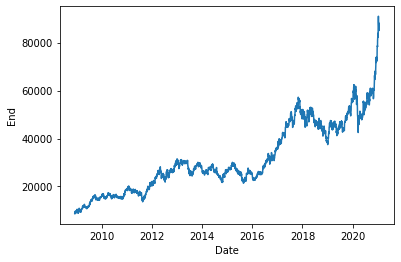

In [135]:
sns.lineplot(data=prices, x='Date', y='End');

In [136]:
prices[prices.index >= '2020-01-01'].iloc[0], prices[prices.index >= '2020-01-01'].iloc[-1]

(Start        55500
 High         56000
 Low          55000
 End          55200
 Amount    12993228
 Name: 2020-01-02 00:00:00, dtype: int64,
 Start        89000
 High         89700
 Low          86800
 End          86800
 Amount    30430330
 Name: 2021-01-22 00:00:00, dtype: int64)



options = Options()
options.add_argument("--headless")
options.add_argument("--no-sandbox")

driver = webdriver.Chrome(options=options)
driver.get('https://www.naver.com')title

driver.current_url

driver.page_source

driver.quit()

## Test Codes